# Setup 

## Imports

In [10]:
# Standard
import sys
from cycler import cycler
# Third party
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import proplot as plot
# Local                         
sys.path.append('/Users/46h/Research/code/accphys') 
from tools import (
    envelope_analysis as ea, 
    plotting as myplt, 
    animation as myanim, 
    utils)
from tools.utils import get_phase_adv, play
from tools.plotting import save, set_labels

## Settings
Choose from the available matplotlib [stylesheets](https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html) and [colormaps](https://matplotlib.org/3.3.3/tutorials/colors/colormaps.html). See [here](https://proplot.readthedocs.io/en/latest/colormaps.html) for a wider range of colormaps from proplot. 

In [218]:
animate = False
plt_kws = dict(legend=False, xlabel='s / L')
plot.rc['figure.facecolor'] = 'white'
plot.rc['cycle'] = 'default'
plot.rc['style'] = None # `None` for default proplot style
plot.rc['savefig.dpi'] = 'figure' # proplot default is 1200, which makes inline animations appear huge

cmap = plot.Colormap('viridis')
cmap_range = (0, 1) # range of the color map to use
dpi = 500

## Read data

Load the files.

In [12]:
tracked_env_params_list = np.load('_output/data/tracked_env_params_list.npy')
transfer_mats = np.load('_output/data/transfer_mats.npy')
perveances = np.load('_output/data/perveances.npy')
positions = np.load('_output/data/positions.npy')
positions_normed = positions / positions[-1]
mode = int(np.loadtxt('_output/data/mode.txt'))

Compute the beam statistics.

In [13]:
stats_list = []

for tracked_env_params in tracked_env_params_list:
    
    stats = ea.Stats(mode)
    stats.read_env(tracked_env_params)
    stats.twiss2D['mux'] = get_phase_adv(stats.twiss2D['bx'], positions, units='deg')
    stats.twiss2D['muy'] = get_phase_adv(stats.twiss2D['by'], positions, units='deg')
    
    # Add position column
    for df in stats.dfs():
        df['s'] = positions
        df['s/L'] = positions_normed
    
    stats_list.append(stats)

Set color cycle from color map.

In [180]:
colors = [cmap(i) for i in np.linspace(cmap_range[0], cmap_range[1], len(stats_list))]
_cycler = cycler('color', colors)

# Within lattice evolution
Show the s-dependent evolution of the beam parameters, with one curve for each value of the beam perveance. The lower end of the colormap corresponds to zero space charge.

## Twiss

### 2D Twiss 

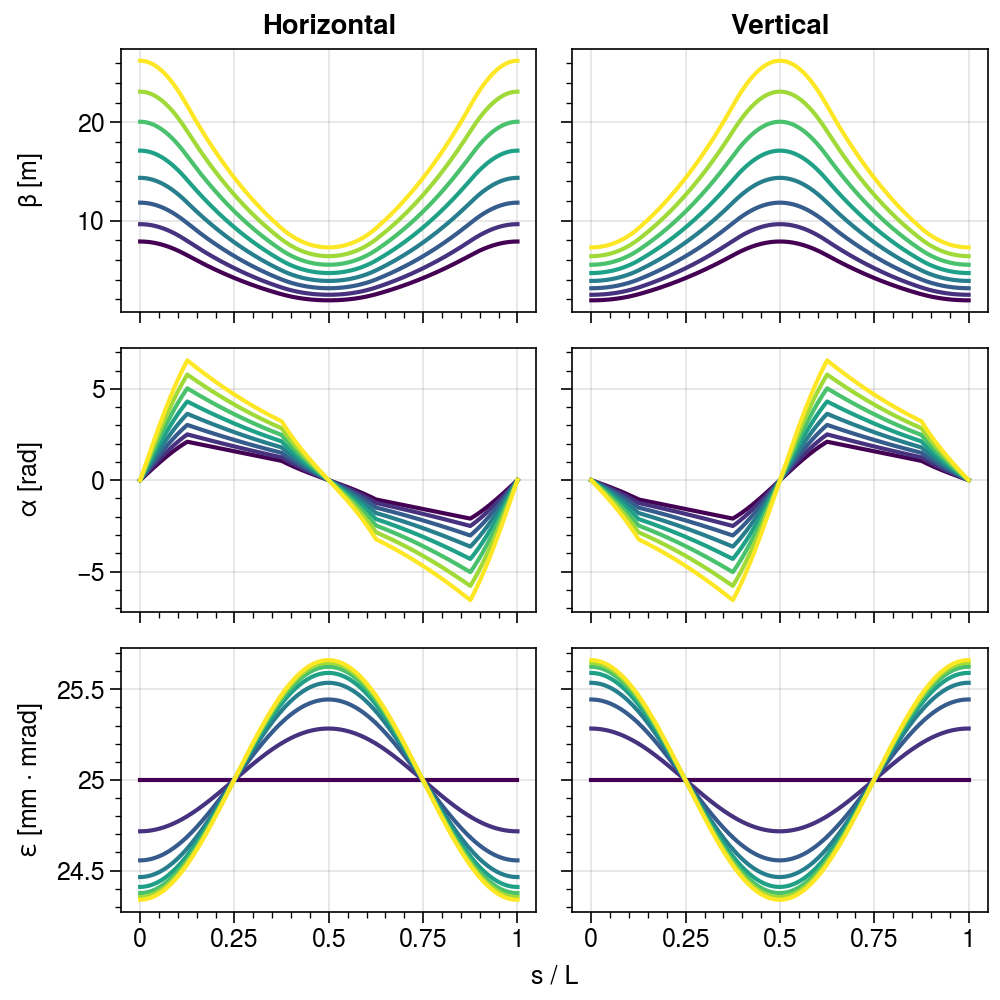

In [15]:
fig, axes = plot.subplots(ncols=2, nrows=3, figsize=(5, 5), spany=False, aligny=True)
axes.set_prop_cycle(_cycler)
cols_list = [['bx','by'], ['ax','ay'], ['ex','ey']]
for stats in stats_list:
    for ax, col in zip(axes, [col for cols in cols_list for col in cols]):
        stats.twiss2D[['s/L', col]].plot('s/L', ax=ax, **plt_kws)
ylabels = [r'$\beta$ [m]', r'$\alpha$ [rad]', r'$\varepsilon$ [mm $\cdot$ mrad]']
set_labels(axes[:, 0], ylabels, 'ylabel')
axes.format(collabels=['Horizontal', 'Vertical'])
plt.savefig('_output/figures/twiss2D.png', dpi=dpi, facecolor='w')

### 4D Twiss

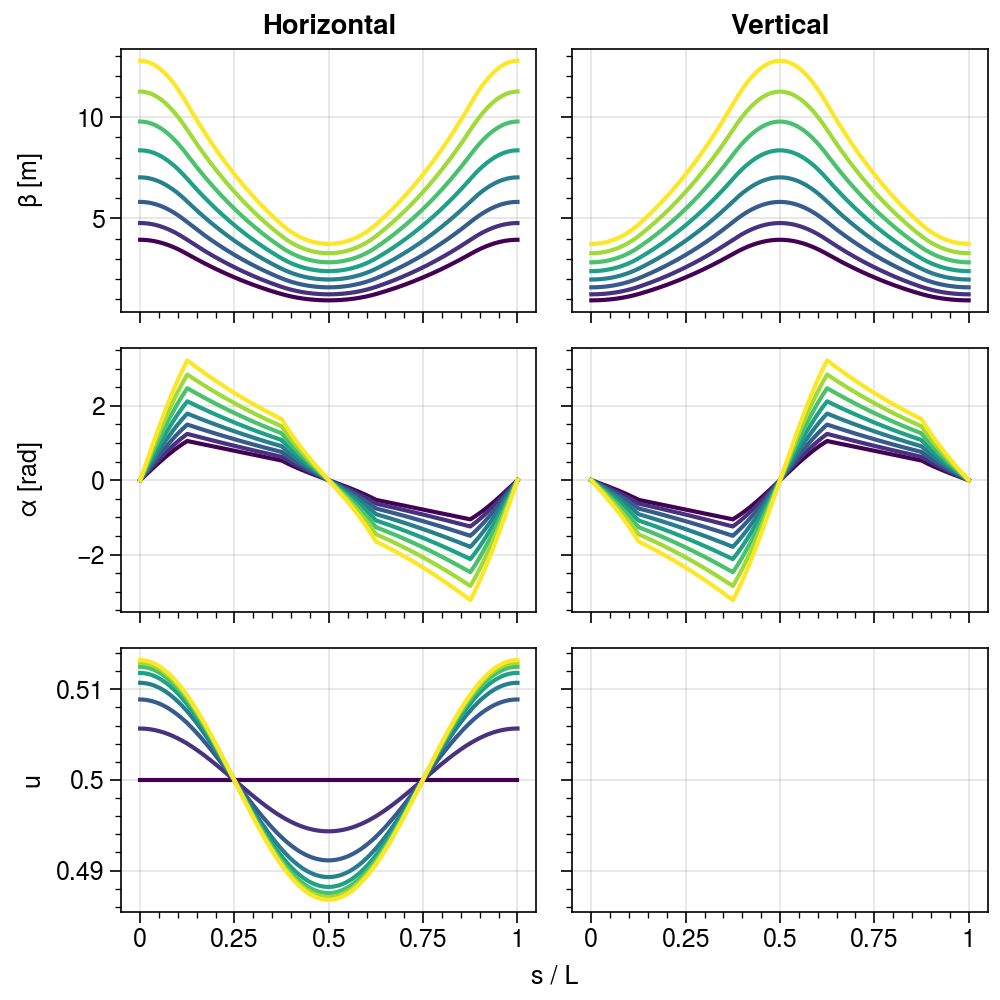

In [16]:
fig, axes = plot.subplots(ncols=2, nrows=3, figsize=(5, 5), spany=False, aligny=True)
axes.set_prop_cycle(_cycler)
cols_list = [['bx','by'], ['ax','ay'], ['u']]
for stats in stats_list:
    for ax, col in zip(axes, [col for cols in cols_list for col in cols]):
        stats.twiss4D[['s/L', col]].plot('s/L', ax=ax, **plt_kws)
set_labels(axes[:, 0], [r'$\beta$ [m]', r'$\alpha$ [rad]', 'u'], 'ylabel')
axes.format(collabels=['Horizontal', 'Vertical'])
plt.savefig('_output/figures/twiss4D.png', dpi=dpi, facecolor='w')

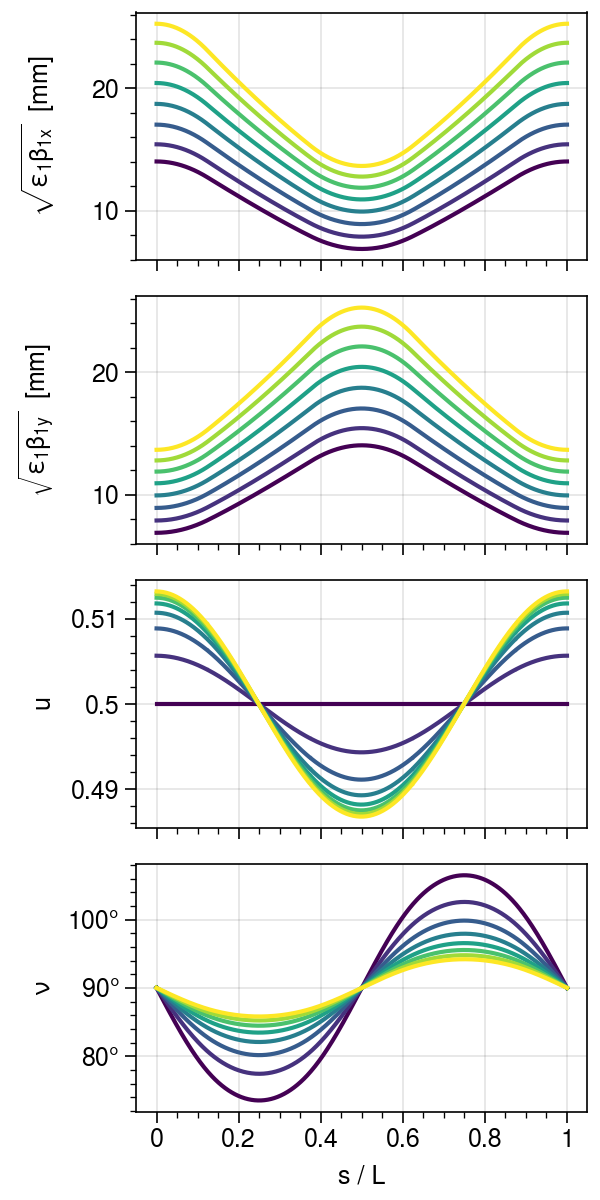

In [17]:
fig, axes = plot.subplots(nrows=4, figsize=(3, 6), spany=False, aligny=True)
axes.set_prop_cycle(_cycler)

if mode == 1:
    ylabels = [r'$\sqrt{\varepsilon_1\beta_{1x}}$  [mm]', r'$\sqrt{\varepsilon_1\beta_{1y}}$  [mm]', r'$u$', r'$\nu$']
elif mode == 2:
    ylabels = [r'$\sqrt{\varepsilon_2\beta_{2x}}$  [mm]', r'$\sqrt{\varepsilon_2\beta_{2y}}$  [mm]', r'$u$', r'$\nu$']
eps = stats.twiss4D['e1'] if mode == 1 else stats.twiss4D['e2']

for stats in stats_list:
    stats.twiss4D['xrms'] = np.sqrt(eps * stats.twiss4D['bx'])
    stats.twiss4D['yrms'] = np.sqrt(eps * stats.twiss4D['by'])
    stats.twiss4D[['s/L','xrms']].plot('s/L', ax=axes[0], **plt_kws)
    stats.twiss4D[['s/L','yrms']].plot('s/L', ax=axes[1], **plt_kws)
    stats.twiss4D[['s/L','u']].plot('s/L', ax=axes[2], **plt_kws)
    stats.twiss4D[['s/L','nu']].plot('s/L', ax=axes[3], **plt_kws)
    
set_labels(axes, ylabels, 'ylabel')
axes[3].format(yformatter='deg')
plt.savefig('_output/figures/twiss4D_alternate.png', dpi=dpi, facecolor='w')

### Phase advance 

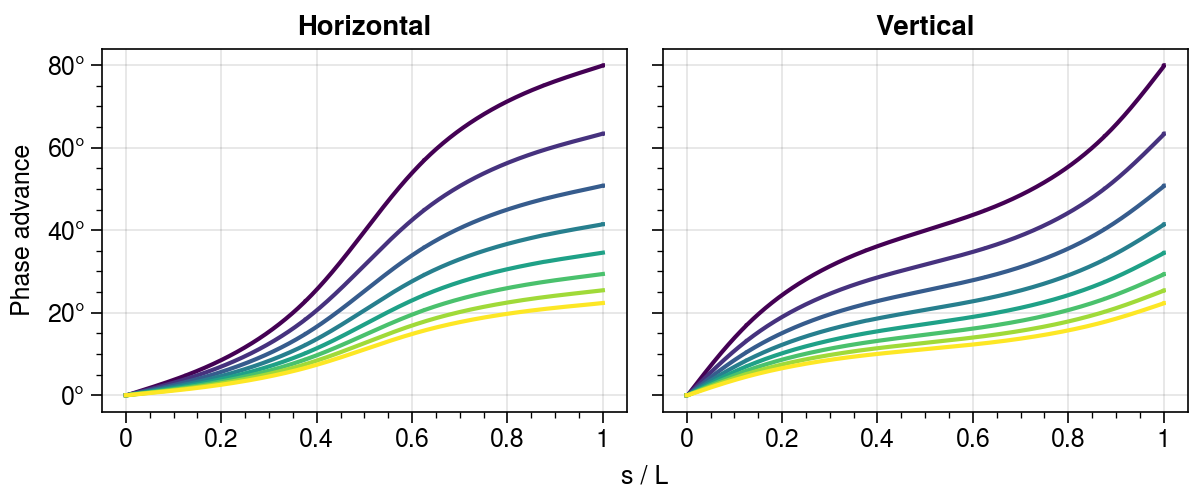

In [18]:
fig, axes = plot.subplots(ncols=2, figsize=(6, 2.5))
axes.set_prop_cycle(_cycler)
for stats in stats_list:
    for ax, col in zip(axes, ['mux', 'muy']):
        stats.twiss2D[['s/L', col]].plot('s/L', ax=ax, **plt_kws)
axes.format(ylabel='Phase advance', yformatter='deg', toplabels=['Horizontal', 'Vertical'])
plt.savefig('_output/figures/phaseadv.png', dpi=dpi, facecolor='w')

### Phase difference (nu)

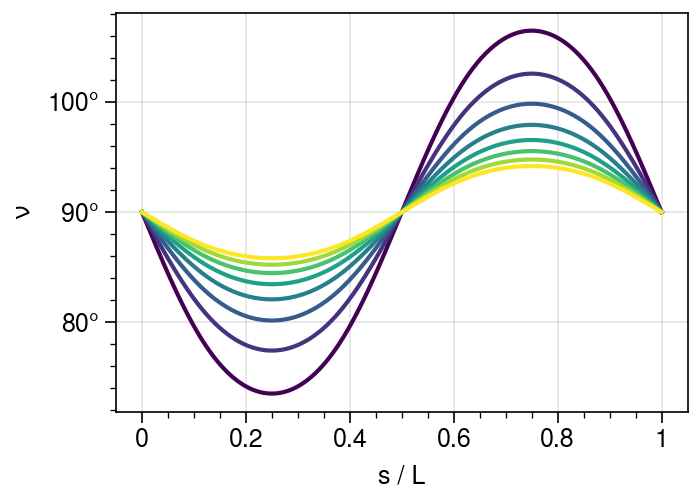

In [19]:
fig, ax = plot.subplots(figsize=(3.5, 2.5))
ax.set_prop_cycle(_cycler)
for stats in stats_list:
    stats.twiss4D[['s/L','nu']].plot('s/L', ax=ax, **plt_kws)
ax.format(ylabel=r'$\nu$', yformatter='deg')
plt.savefig('_output/figures/nu.png', dpi=dpi, facecolor='w')

## Moments 

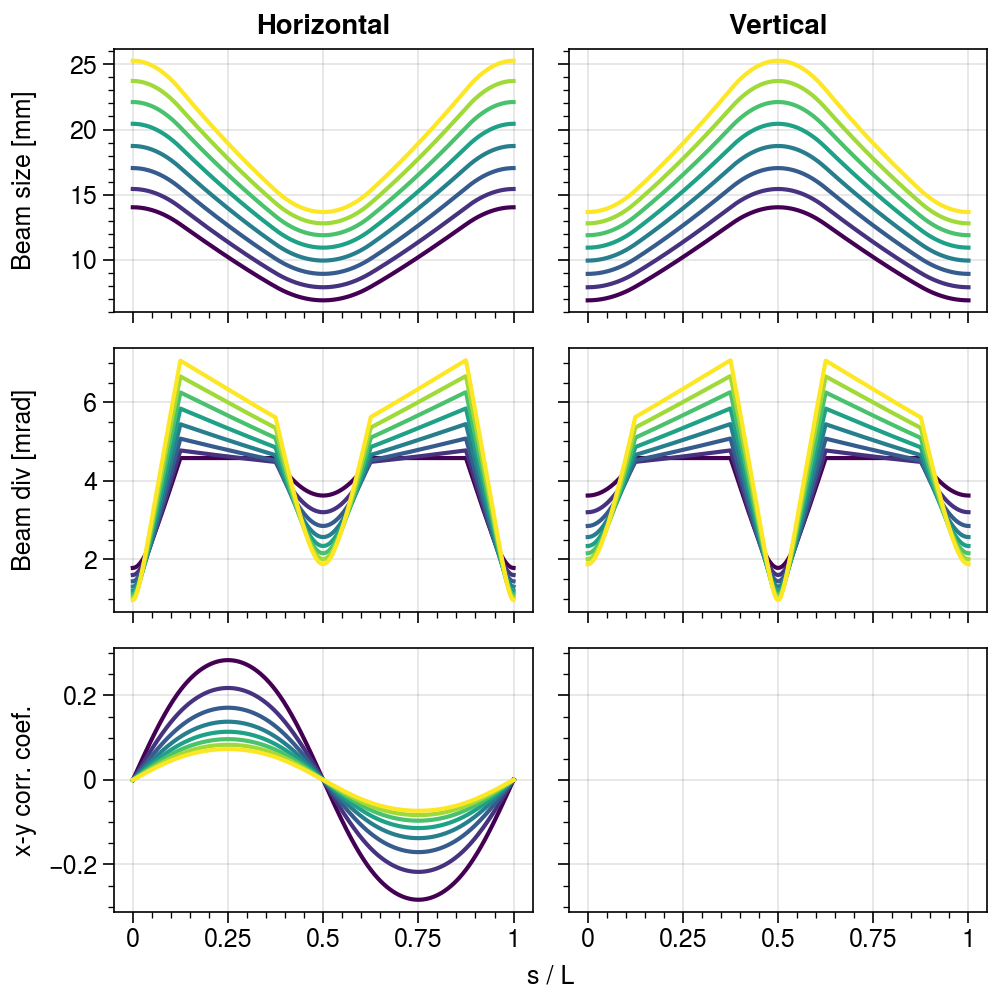

In [20]:
fig, axes = plot.subplots(ncols=2, nrows=3, figsize=(5, 5), spany=False, aligny=True)
axes.set_prop_cycle(_cycler)
cols_list = [['x_rms','y_rms'], ['xp_rms','yp_rms']]
for stats in stats_list:
    for ax, col in zip(axes, [col for cols in cols_list for col in cols]):
        stats.moments[['s/L', col]].plot('s/L', ax=ax, **plt_kws)
    stats.corr[['s/L','xy']].plot('s/L', ax=axes[2, 0], **plt_kws)
ylabels = ['Beam size [mm]', 'Beam div [mrad]', 'x-y corr. coef.']
set_labels(axes[:, 0], ylabels, 'ylabel')
axes.format(toplabels=['Horizontal', 'Vertical'])
plt.savefig('_output/figures/moments.png', dpi=dpi, facecolor='w')

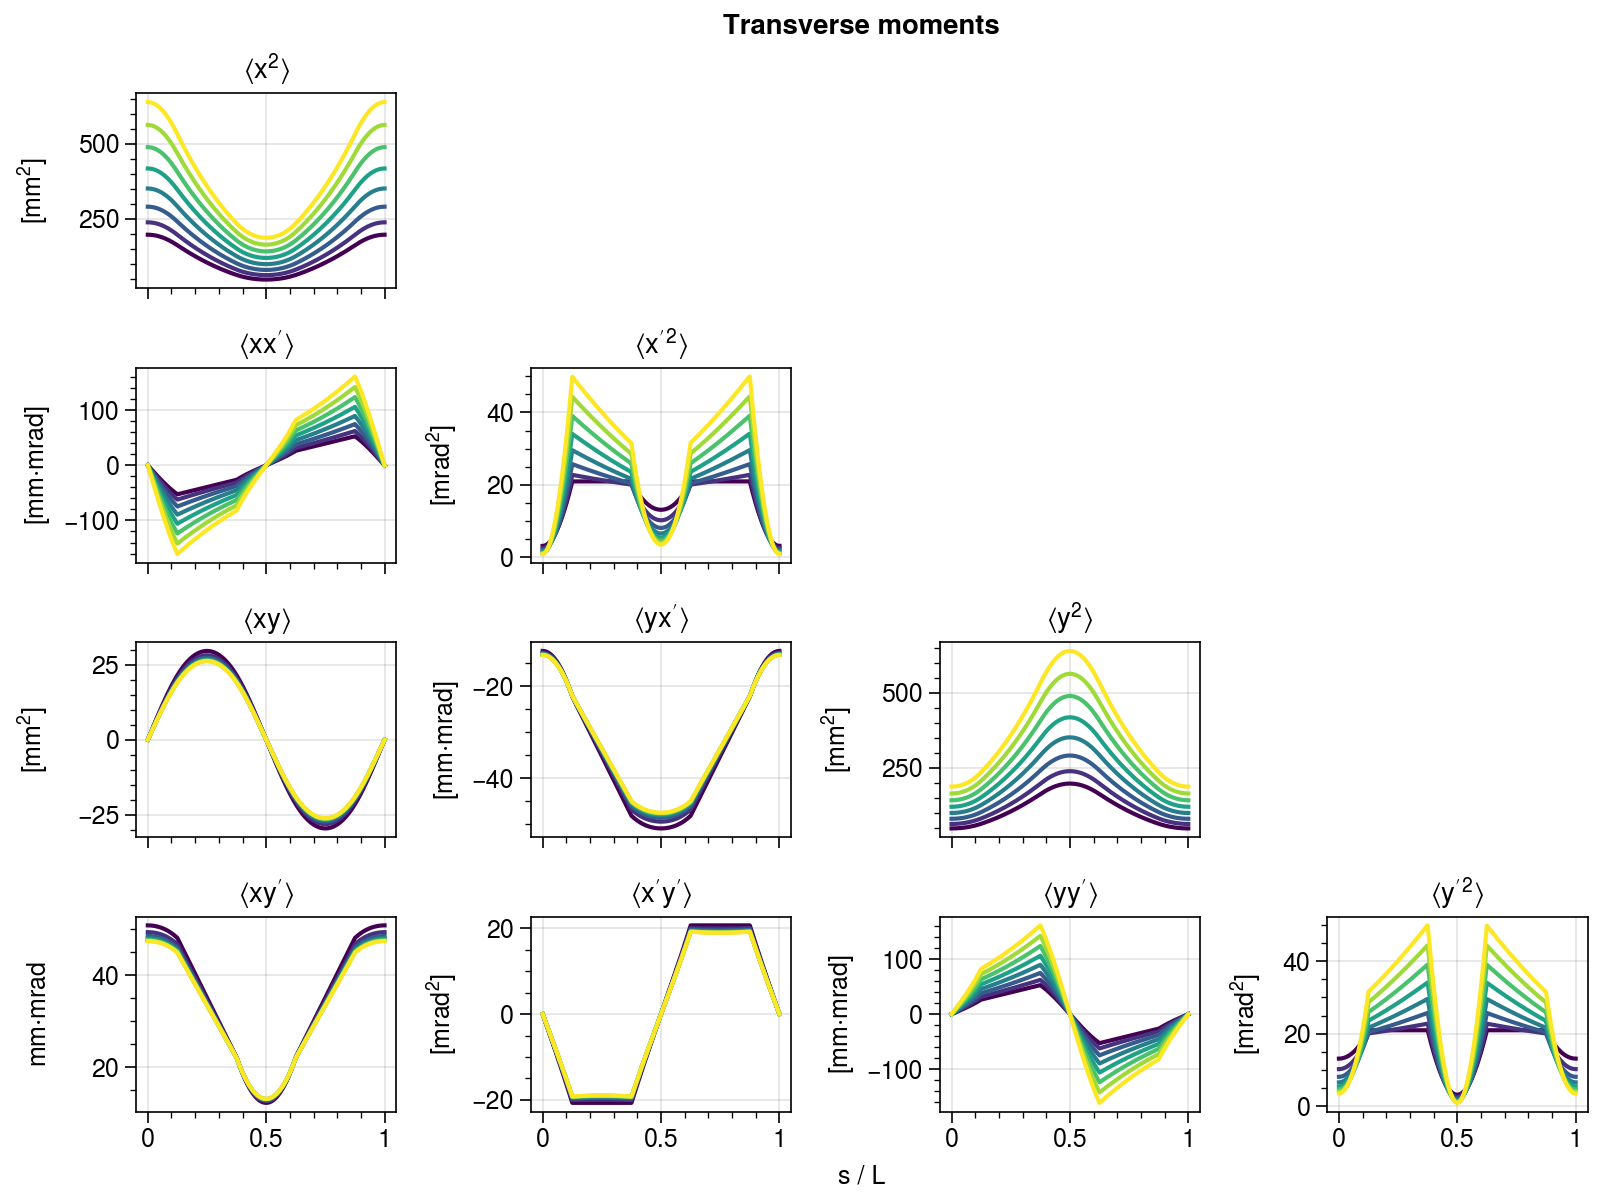

In [21]:
fig, axes = plot.subplots(nrows=4, ncols=4, sharey=False, figsize=(8, 6), 
                          spany=False, aligny=True)
myplt.make_lower_triangular(axes)
axes.set_prop_cycle(_cycler)
axes.format(xlabel='s / L', suptitle='Transverse moments', titleborder=True)

for stats in stats_list:
    for i in range(4):
        for j in range(i + 1):
            ax = axes[i, j]
            col = utils.get_moments_key(i, j)
            stats.moments[['s/L',col]].plot('s/L', ax=ax, **plt_kws)
            ax.format(title=utils.get_moments_label(i, j))

set_labels(axes[0:, 0], [r'[mm$^2$]', r'[mm$\cdot$mrad]', r'[mm$^2$]', r'mm$\cdot$mrad'], 'ylabel')
set_labels(axes[1:, 1], [r'[mrad$^2$]', r'[mm$\cdot$mrad]', r'[mrad$^2$]'], 'ylabel')
set_labels(axes[2:, 2], [r'[mm$^2$]', r'[mm$\cdot$mrad]'], 'ylabel')
set_labels(axes[3:, 3], [r'[mrad$^2$]'], 'ylabel')
plt.savefig('_output/figures/all_moments.png', dpi=dpi, facecolor='w')

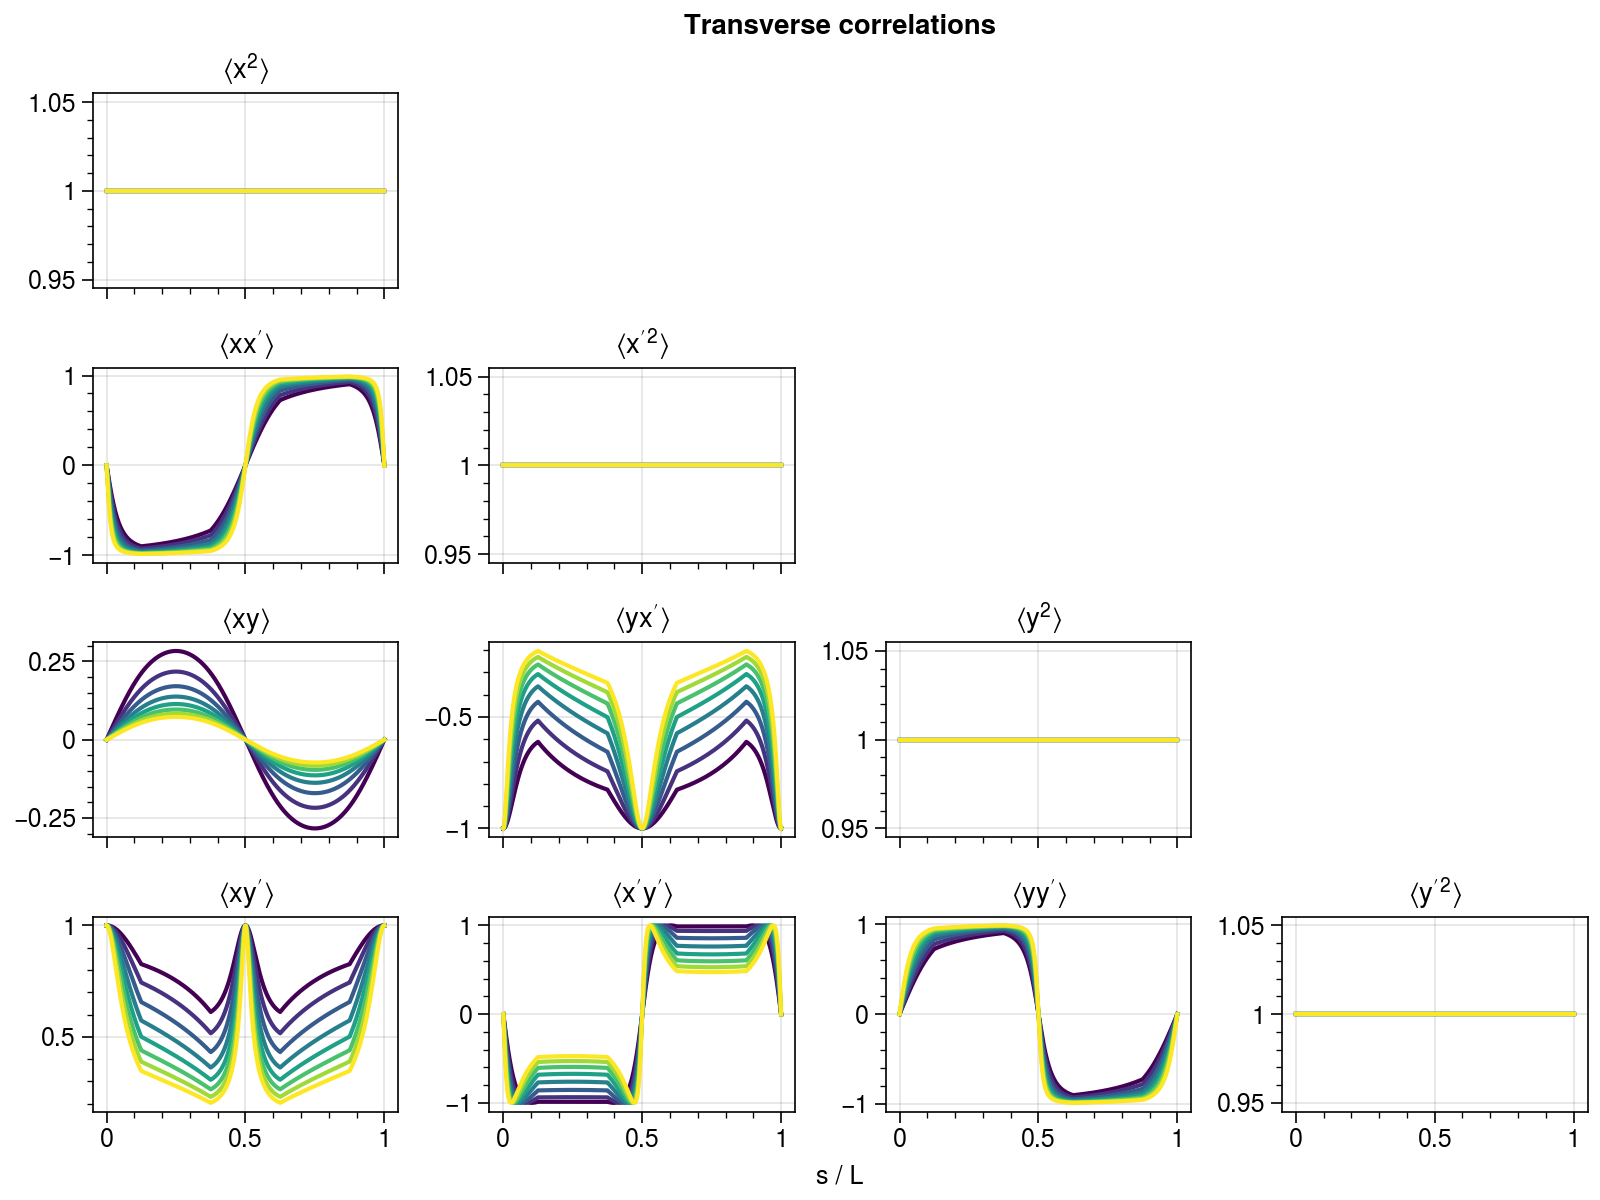

In [22]:
fig, axes = plot.subplots(nrows=4, ncols=4, sharey=False, figsize=(8, 6), 
                          spany=False, aligny=True)
myplt.make_lower_triangular(axes)
axes.set_prop_cycle(_cycler)
axes.format(xlabel='s / L', suptitle='Transverse correlations', titleborder=True)

for stats in stats_list:
    for i in range(4):
        for j in range(i + 1):
            ax = axes[i, j]
            col = utils.get_moments_key(i, j)
            stats.corr[['s/L',col]].plot('s/L', ax=ax, **plt_kws)
            ax.format(title=utils.get_moments_label(i, j))
            
plt.savefig('_output/figures/all_correlations.png', dpi=dpi, facecolor='w')

## Real space orientation 

In [28]:
# Choose 'area' for true area in x-y space, or 'area_rel' for fractional change
area = 'area_rel'

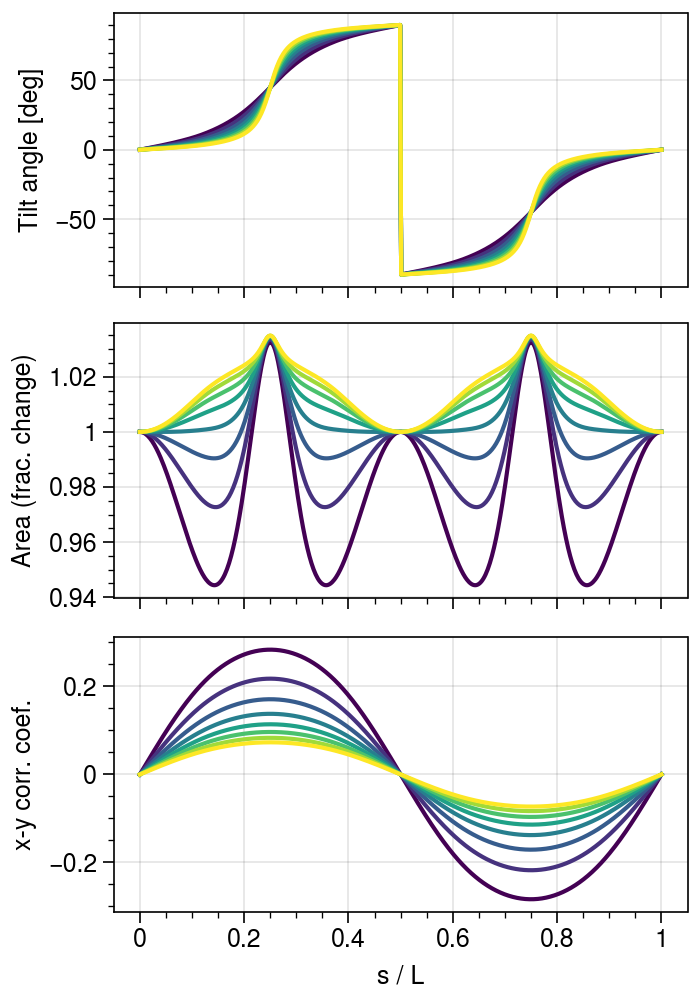

In [29]:
if area == 'area':
    area_ylabel = r'Area [mm$^2$]' 
elif area == 'area_rel':
    area_ylabel = r'Area (frac. change)' 

fig, axes = plot.subplots(ncols=1, nrows=3, sharey=False, figsize=(3.5, 5))
axes.set_prop_cycle(_cycler)
for stats in stats_list:
    stats.realspace[['s/L','angle']].plot('s/L', ax=axes[0], **plt_kws)
    stats.realspace[['s/L', area]].plot('s/L', ax=axes[1], **plt_kws)
    stats.corr[['s/L','xy']].plot('s/L', ax=axes[2], **plt_kws)
ylabels = ['Tilt angle [deg]', area_ylabel, 'x-y corr. coef.']
set_labels(axes, ylabels, 'ylabel')
plt.savefig('_output/figures/real_space_orientation.png', dpi=dpi, facecolor='w')

Charge density

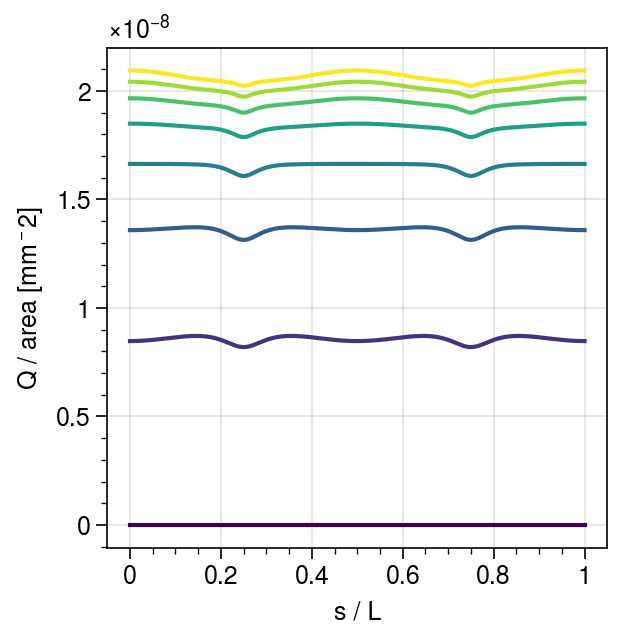

In [25]:
fig, ax = plot.subplots()
ax.set_prop_cycle(_cycler)
for stats, Q in zip(stats_list, perveances):
    stats.realspace['charge_densiy'] = Q / stats.realspace['area']
    stats.realspace[['s/L','charge_densiy']].plot('s/L', ax=ax, **plt_kws)
ax.format(ylabel='Q / area [mm$^-2$]')

## Miscellanneous

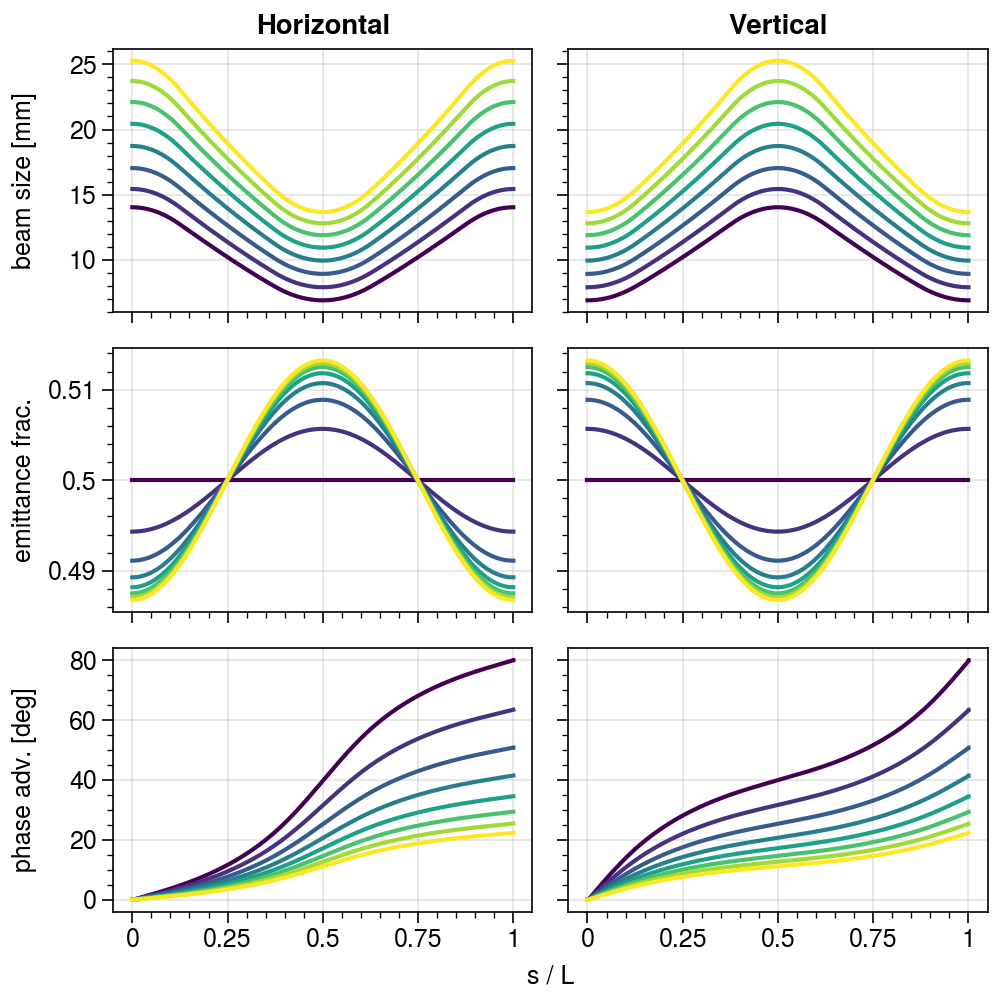

In [26]:
fig, axes = plot.subplots(ncols=2, nrows=3, figsize=(5, 5), spany=False, aligny=True)
axes.set_prop_cycle(_cycler)
for stats in stats_list:
    stats.moments[['s/L','x_rms']].plot('s/L', ax=axes[0, 0], **plt_kws)
    stats.moments[['s/L','y_rms']].plot('s/L', ax=axes[0, 1], **plt_kws)
    stats.twiss2D[['s/L','ex_frac']].plot('s/L', ax=axes[1, 0], **plt_kws)
    stats.twiss2D[['s/L','ey_frac']].plot('s/L', ax=axes[1, 1], **plt_kws)
    stats.twiss2D[['s/L','mux']].plot('s/L', ax=axes[2, 0], **plt_kws)
    stats.twiss2D[['s/L','muy']].plot('s/L', ax=axes[2, 1], **plt_kws)
    
ylabels = ['beam size [mm]', 'emittance frac.', 'phase adv. [deg]']
set_labels(axes[:, 0], ylabels, 'ylabel')
axes.format(toplabels=['Horizontal', 'Vertical'])
plt.savefig('_output/figures/size_emittance_phaseadv.png', dpi=dpi, facecolor='w')

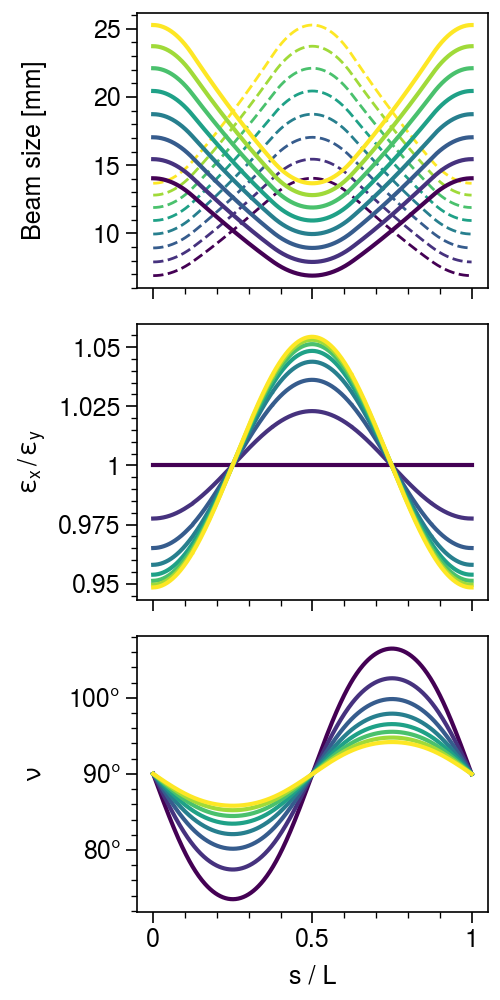

In [228]:
fig, axes = plot.subplots(ncols=1, nrows=3, sharey=False, figsize=(2.5, 5), aligny=True)

axes.set_prop_cycle(_cycler)
for stats in stats_list:
    stats.moments[['s/L','x_rms']].plot('s/L', ax=axes[0], **plt_kws)
    stats.twiss2D['ex/ey'] = stats.twiss2D['ex'] / stats.twiss2D['ey']
    stats.twiss2D[['s/L','ex/ey']].plot('s/L', ax=axes[1], **plt_kws)
    stats.twiss4D[['s/L','nu']].plot('s/L', ax=axes[2], **plt_kws)
    
axes.set_prop_cycle(_cycler)
for stats in stats_list:
    stats.moments[['s/L','y_rms']].plot('s/L', ax=axes[0], ls='--', zorder=0, lw=1, **plt_kws)
    
axes[2].format(yformatter='deg')
axes.format(grid=False)
set_labels(axes, ['Beam size [mm]', r'$\varepsilon_x\,/\,\varepsilon_y$', r'$\nu$'], 'ylabel')

plt.savefig('_output/figures/_fig.png', dpi=dpi, facecolor='w')

## Phase space projections 

In [60]:
if animate:
    anim = myanim.corner_env(tracked_env_params_list, cmap=cmap, skip=10, figsize=6, 
                             text_vals=positions_normed, text_fmt='s / L = {:.2f}')
    play(anim)

# Fixed position in lattice

In [172]:
position_to_observe = 0.0 # in units s/L
ind_var_name = 'Q'
ind_var_vals = perveances
discrete_kws = dict(lw=0, marker='o', legend=False)

Collect the parameters at this position.

In [173]:
i = 0
for index, position_normed in enumerate(positions_normed):
    if position_normed >= position_to_observe:
        i = index
        s = position_normed
        break
print('Closest index is {}, with s/L = {:.3f}'.format(i, s))

Closest index is 0, with s/L = 0.000


In [174]:
env_params_fixedpt = tracked_env_params_list[:, i, :]

twiss2D_fixedpt = pd.DataFrame(
    np.array([stats.twiss2D.iloc[i].values for stats in stats_list]),
    columns=stats.twiss2D.columns
)
twiss4D_fixedpt = pd.DataFrame(
    np.array([stats.twiss4D.iloc[i].values for stats in stats_list]),
    columns=stats.twiss4D.columns
)
moments_fixedpt = pd.DataFrame(
    np.array([stats.moments.iloc[i].values for stats in stats_list]),
    columns=stats.moments.columns
)
corr_fixedpt = pd.DataFrame(
    np.array([stats.corr.iloc[i].values for stats in stats_list]),
    columns=stats.corr.columns
)
realspace_fixedpt = pd.DataFrame(
    np.array([stats.realspace.iloc[i].values for stats in stats_list]),
    columns=stats.realspace.columns
)
for df in [twiss2D_fixedpt, twiss4D_fixedpt, moments_fixedpt, corr_fixedpt, realspace_fixedpt]:
    df[ind_var_name] = ind_var_vals
    
twiss4D_fixedpt

,ax,ay,bx,by,u,nu,e1,e2,e4D,s,s/L,xrms,yrms,Q
0,-1.268269e-16,3.522969e-17,3.941449,0.952015,0.500000,90.000000,50.0,0.0,50.0,0.0,0.0,14.038249,6.899331,0.000000
1,-9.265771e-06,-4.367320e-06,4.767276,1.249233,0.505674,89.999775,50.0,0.0,50.0,0.0,0.0,15.439035,7.903269,0.000013
2,-1.824524e-05,-8.752056e-06,5.809726,1.594940,0.508881,89.999822,50.0,0.0,50.0,0.0,0.0,17.043658,8.930118,0.000026
3,-2.711858e-05,-1.314361e-05,7.021170,1.980032,0.510721,89.999856,50.0,0.0,50.0,0.0,0.0,18.736555,9.949956,0.000039
4,-3.595945e-05,-1.753734e-05,8.355196,2.394290,0.511814,89.999881,50.0,0.0,50.0,0.0,0.0,20.439173,10.941413,0.000052
5,-4.479471e-05,-2.193149e-05,9.775169,2.829230,0.512491,89.999899,50.0,0.0,50.0,0.0,0.0,22.107882,11.893759,0.000065
6,-5.363306e-05,-2.632547e-05,11.255128,3.278699,0.512930,89.999913,50.0,0.0,50.0,0.0,0.0,23.722488,12.803709,0.000078
7,-6.247669e-05,-3.071914e-05,12.777454,3.738472,0.513227,89.999923,50.0,0.0,50.0,0.0,0.0,25.275931,13.672000,0.000091


In [175]:
realspace_fixedpt['charge_density'] = realspace_fixedpt['Q'] / realspace_fixedpt['area'] # Note the units
realspace_fixedpt['charge_density_rel'] = realspace_fixedpt['Q'] / realspace_fixedpt['area_rel']

## Twiss 

### 2D Twiss 
Blue and orange correspond to $x$ and $y$, respectively.

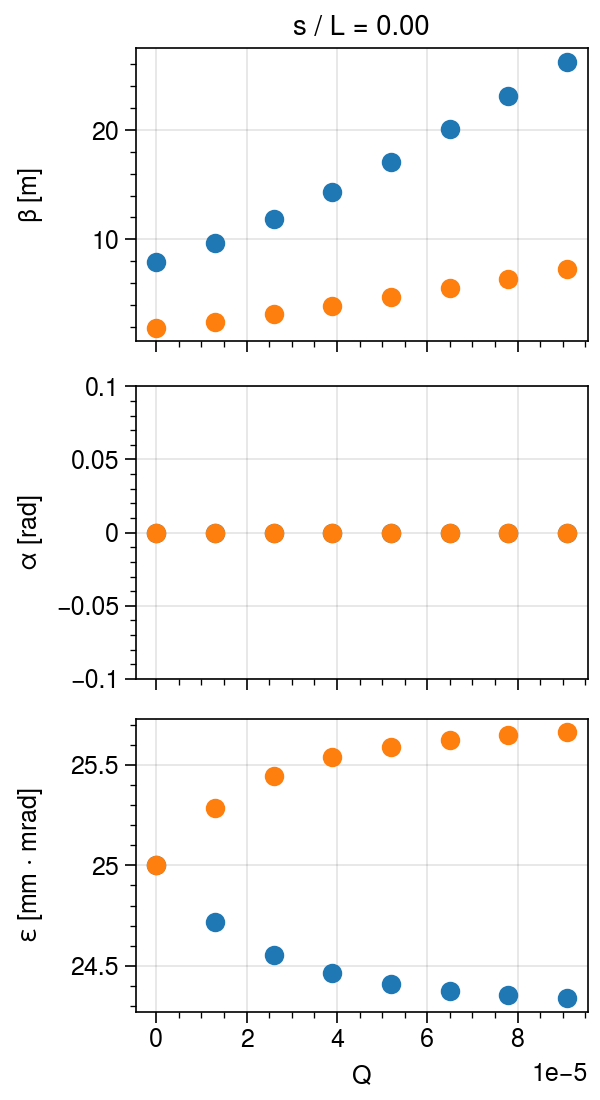

In [176]:
fig, axes = plot.subplots(nrows=3, figsize=(3, 5.5), sharey=False, aligny=True)
twiss2D_fixedpt[[ind_var_name,'bx','by']].plot(ind_var_name, ax=axes[0], **discrete_kws)
twiss2D_fixedpt[[ind_var_name,'ax','ay']].plot(ind_var_name, ax=axes[1], **discrete_kws)
twiss2D_fixedpt[[ind_var_name,'ex', 'ey']].plot(ind_var_name, ax=axes[2], **discrete_kws)
axes.format(xformatter='scalar')
axes[0].format(title='s / L = {:.2f}'.format(s))
axes[1].format(ylim=(-0.1, 0.1))
ylabels = [r'$\beta$ [m]', r'$\alpha$ [rad]', r'$\varepsilon$ [mm $\cdot$ mrad]']
set_labels(axes, ylabels, 'ylabel')
plt.savefig('_output/figures/twiss2D_fixedpt.png', dpi=dpi, facecolor='w')

### 4D Twiss 

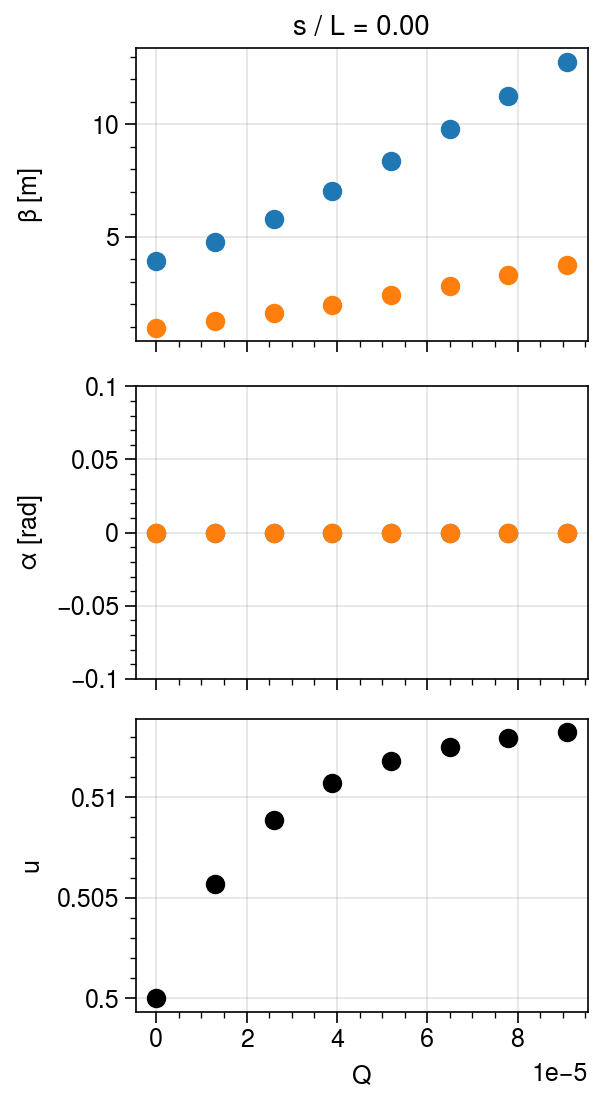

In [177]:
fig, axes = plot.subplots(nrows=3, figsize=(3, 5.5), sharey=False, aligny=True)
twiss4D_fixedpt[[ind_var_name,'bx','by']].plot(ind_var_name, ax=axes[0], **discrete_kws)
twiss4D_fixedpt[[ind_var_name,'ax','ay']].plot(ind_var_name, ax=axes[1], **discrete_kws)
twiss4D_fixedpt[[ind_var_name,'u']].plot(ind_var_name, ax=axes[2], c='k', **discrete_kws)
axes[0].format(title='s / L = {:.2f}'.format(s))
axes.format(xformatter='scalar')
axes[1].format(ylim=(-0.1, 0.1))
set_labels(axes, [r'$\beta$ [m]', r'$\alpha$ [rad]', 'u'], 'ylabel')
plt.savefig('_output/figures/twiss4D_fixedpt.png', dpi=dpi, facecolor='w')

### Phase advance 

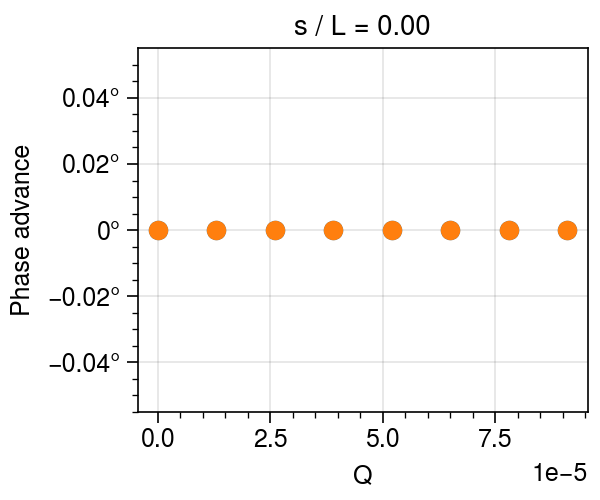

In [67]:
fig, ax = plot.subplots(figsize=(3, 2.5))
twiss2D_fixedpt[[ind_var_name,'mux','muy']].plot(ind_var_name, ax=ax, **discrete_kws)
ax.format(title='s / L = {:.2f}'.format(s), xformatter='scalar')
ax.format(xformatter='scalar', yformatter='deg', ylabel='Phase advance')
plt.savefig('_output/figures/phaseadv_fixedpt.png', dpi=dpi, facecolor='w')

### Phase difference (nu)

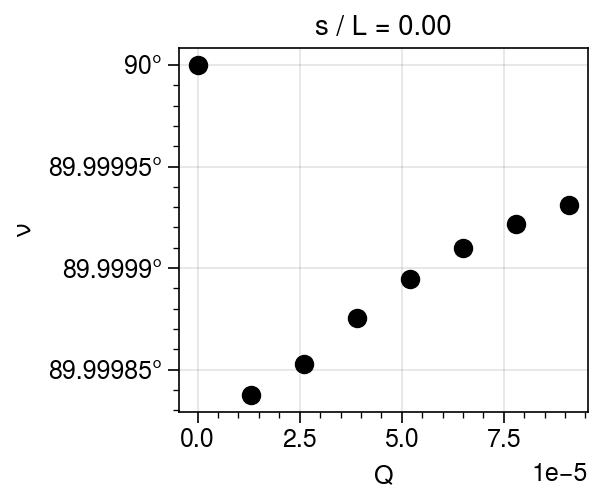

In [68]:
fig, ax = plot.subplots(figsize=(3, 2.5))
twiss4D_fixedpt[[ind_var_name,'nu']].plot(ind_var_name, ax=ax, color='k', **discrete_kws)
ax.format(title='s / L = {:.2f}'.format(s), xformatter='scalar')
ax.format(yformatter='deg', xformatter='scalar', ylabel=r'$\nu$')
plt.savefig('_output/figures/nu_fixedpt.png', dpi=dpi, facecolor='w')

## Moments 

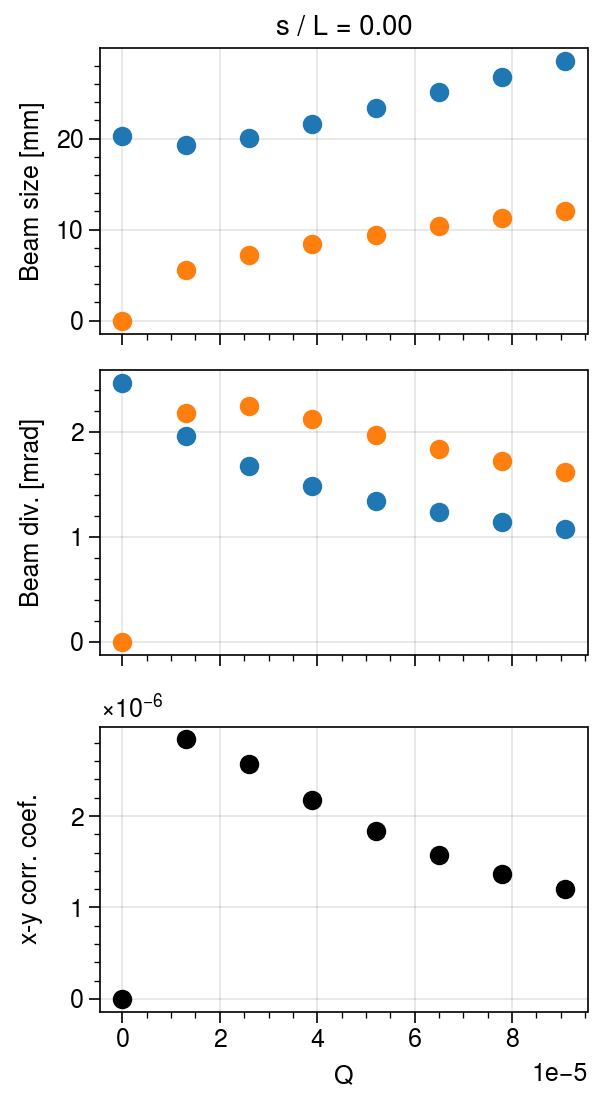

In [69]:
fig, axes = plot.subplots(nrows=3, figsize=(3, 5.5), sharey=False, aligny=True)
moments_fixedpt[[ind_var_name,'x_rms','y_rms']].plot(ind_var_name, ax=axes[0], **discrete_kws)
moments_fixedpt[[ind_var_name,'xp_rms','yp_rms']].plot(ind_var_name, ax=axes[1], **discrete_kws)
corr_fixedpt[[ind_var_name,'xy']].plot(ind_var_name, ax=axes[2], color='k', **discrete_kws)
axes[0].format(title='s / L = {:.2f}'.format(s))
axes.format(xformatter='scalar')
ylabels = ['Beam size [mm]', 'Beam div. [mrad]', r'$x$-$y$ corr. coef.']
set_labels(axes, ylabels, 'ylabel')
plt.savefig('_output/figures/moments_fixedpt.png', dpi=dpi, facecolor='w')

## Real space orientation

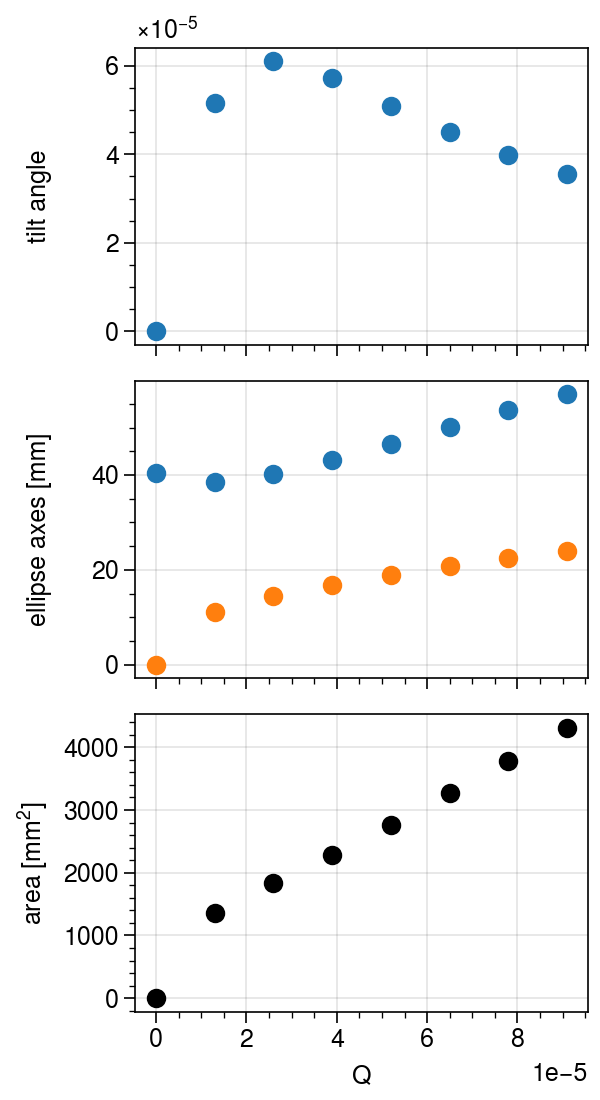

In [70]:
fig, axes = plot.subplots(nrows=3, figsize=(3, 5.5), sharey=False, aligny=True)
realspace_fixedpt[[ind_var_name,'angle']].plot(ind_var_name, ax=axes[0], **discrete_kws)
realspace_fixedpt[[ind_var_name,'cx','cy']].plot(ind_var_name, ax=axes[1], **discrete_kws)
realspace_fixedpt[[ind_var_name,'area']].plot(ind_var_name, ax=axes[2], color='k', **discrete_kws)
set_labels(axes, ['tilt angle', 'ellipse axes [mm]', 'area [mm$^2$]'], 'ylabel')
axes.format(xformatter='scalar')
plt.savefig('_output/figures/realspace_orientation_fixedpt.png', dpi=dpi, facecolor='w')

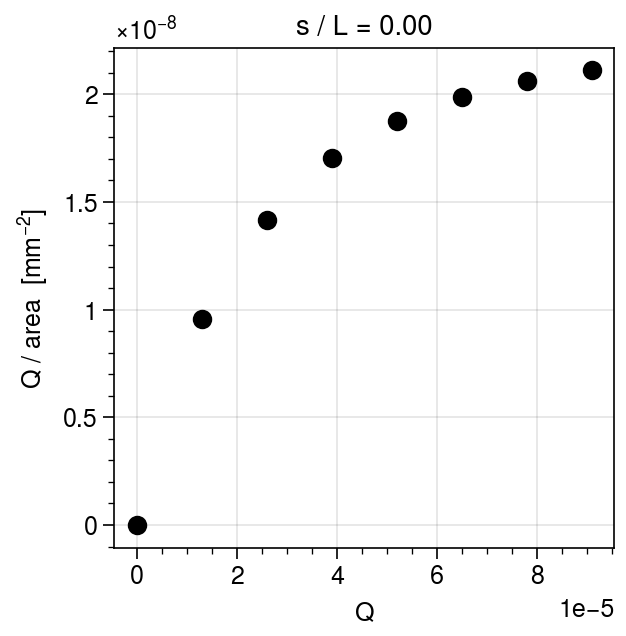

In [71]:
fig, ax = plot.subplots()
realspace_fixedpt[[ind_var_name,'charge_density']].plot(ind_var_name, ax=ax, color='k', **discrete_kws)
ax.format(title='s / L = {:.2f}'.format(s), xformatter='scalar', xlabel='Q', ylabel='Q / area  [mm$^{-2}$]')
plt.savefig('_output/figures/charge_density.png', dpi=dpi, facecolor='w')

## Phase space projections

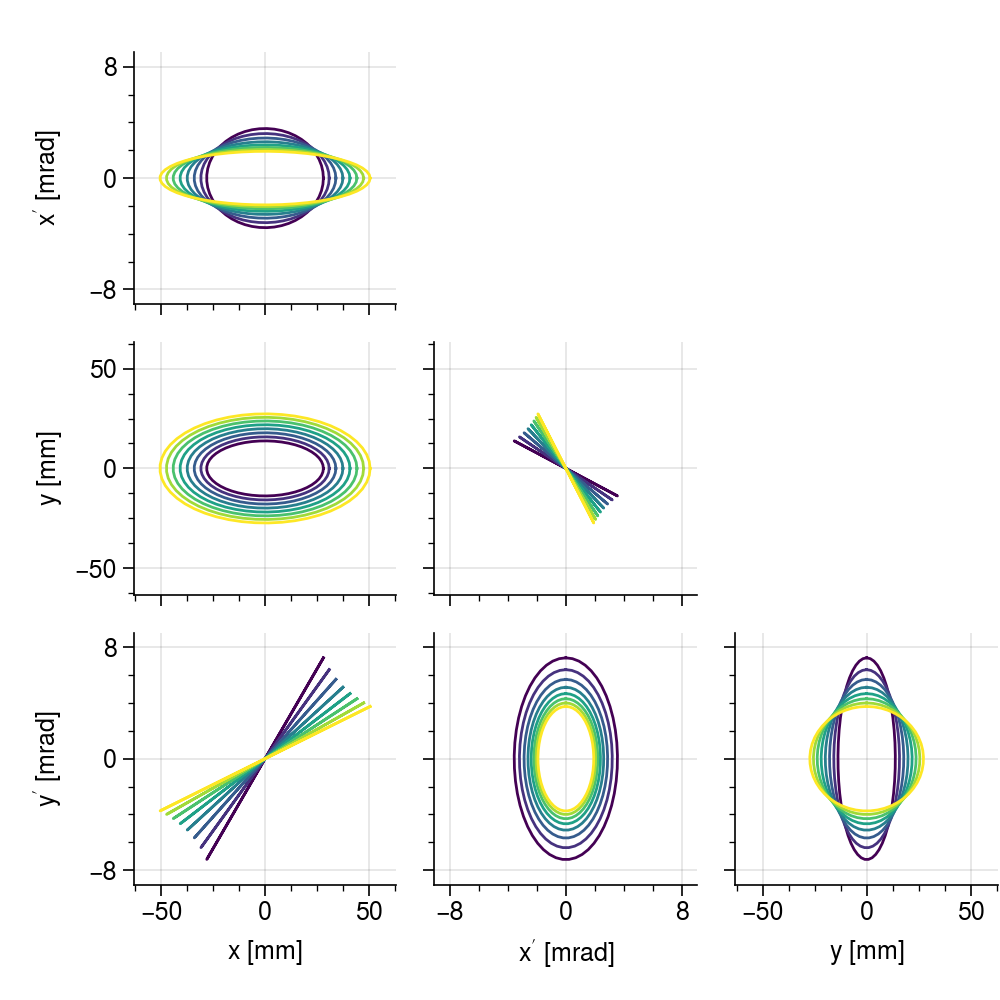

In [219]:
axes = myplt.corner_env(env_params_fixedpt, figsize=5, pad=0.25, lw=1,
                        cmap=cmap, cmap_range=cmap_range)
plt.savefig('_output/figures/corner.png', dpi=dpi, facecolor='w')

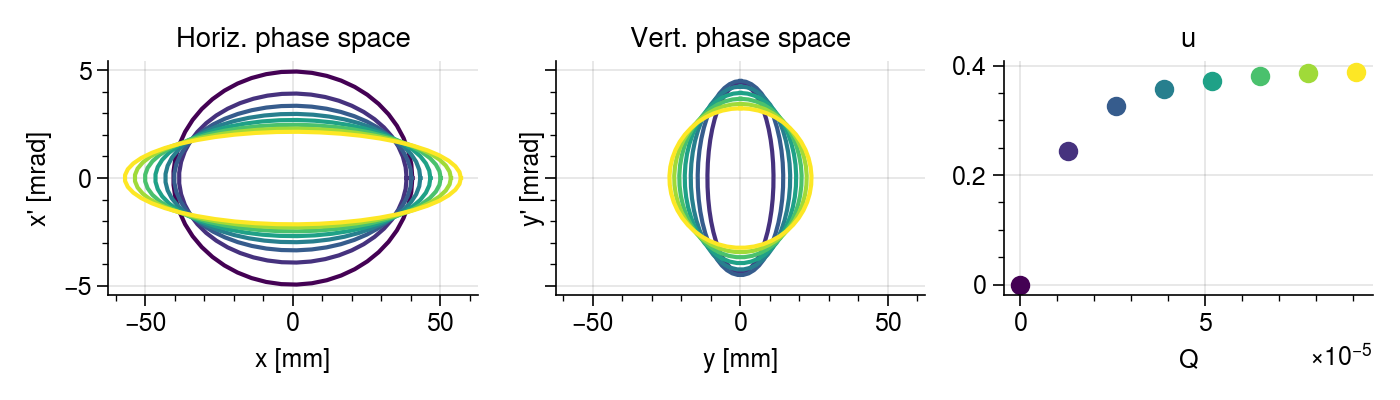

In [73]:
env_coords_fixedpt = ea.get_ellipse_coords(env_params_fixedpt)

fig, axes = plt.subplots(1, 3, figsize=(7, 2), tight_layout=True)
myplt.despine(axes)
myplt.set_share_axes(axes[:2], sharex=True, sharey=True)
for ax in axes:
    ax.set_prop_cycle(_cycler)

for X in env_coords_fixedpt:
    x, xp, y, yp = X.T
    axes[0].plot(x, xp)
    axes[1].plot(y, yp)
for ind_var_val, u in zip(ind_var_vals, twiss4D_fixedpt.loc[:, 'u']):
    axes[2].plot(ind_var_val, u, 'o')

set_labels(axes, ["x [mm]", "y [mm]", "Q"], 'xlabel')
set_labels(axes, ["x' [mrad]", "y' [mrad]"], 'ylabel')
set_labels(axes, ['Horiz. phase space', 'Vert. phase space', 'u'], 'title')
plt.savefig('_output/figures/horz_vert_phasespace.png', dpi=dpi, facecolor='w')

# Effective transfer matrix 

In [74]:
max_number_of_columns = 8

In [75]:
n = len(transfer_mats)
ncols = n if n <= max_number_of_columns else max_number_of_columns
nrows = int(np.ceil(n / max_number_of_columns))

## Eigenvalues 

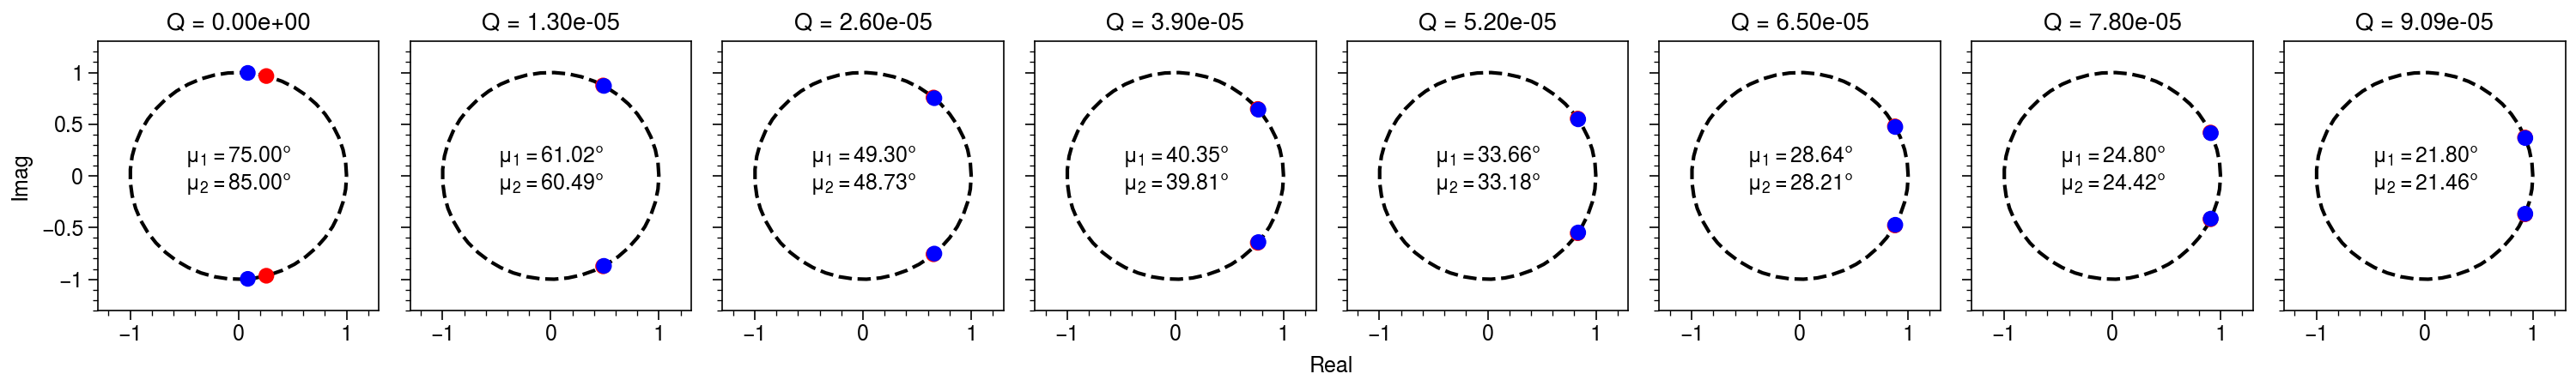

In [76]:
fig, axes = plot.subplots(ncols=ncols, nrows=nrows, figsize=(15, nrows*2.25))
axes.format(grid=False, xlim=(-1.3, 1.3), ylim=(-1.3, 1.3), xlabel='Real', ylabel='Imag')

psi = np.linspace(0, 2*np.pi, 50)
x_circle, y_circle = np.cos(psi), np.sin(psi)

for ax, M, ind_var_val in zip(axes, transfer_mats, ind_var_vals):
    ax.plot(x_circle, y_circle, 'k--', zorder=0)
    if not np.any(np.isnan(M)):
        eigvals = np.linalg.eigvals(M)
        eigtunes = np.degrees(np.arccos(eigvals.real))
        ax.scatter(eigvals.real, eigvals.imag, c=['r','r','b','b'], zorder=2)
        ax.annotate(r'$\mu_1 = {:.2f}\degree$'.format(eigtunes[0]), xy=(0.5, 0.55), xycoords='axes fraction', horizontalalignment='center')
        ax.annotate(r'$\mu_2 = {:.2f}\degree$'.format(eigtunes[2]), xy=(0.5, 0.45), xycoords='axes fraction', horizontalalignment='center')
    ax.format(title='{} = {:.2e}'.format(ind_var_name, ind_var_val))
    ax.invert_xaxis() # ?

plt.savefig('_output/figures/transfer_mat_eigvals.png', dpi=dpi, facecolor='w')

## Eigenvectors 

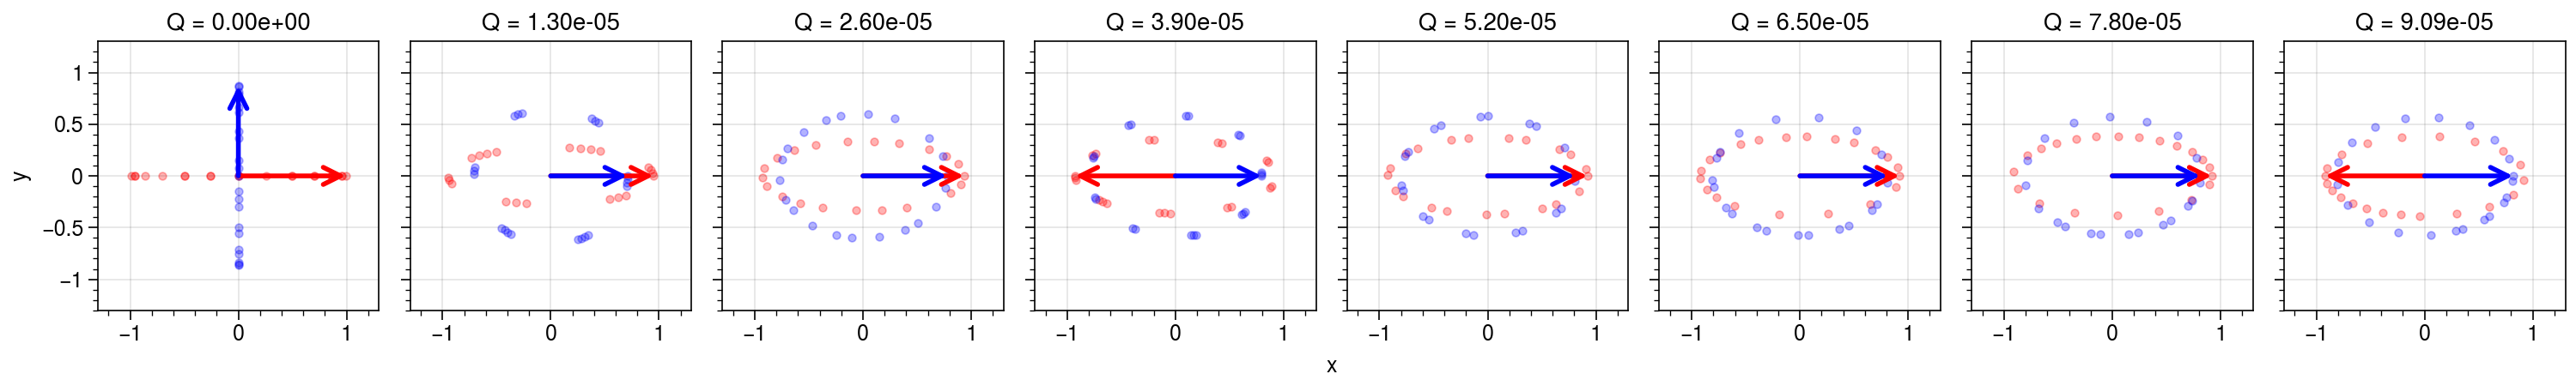

In [77]:
fig, axes = plot.subplots(ncols=ncols, nrows=nrows, figsize=(15, nrows*2.25))
axes.format(xlim=(-1.3, 1.3), ylim=(-1.3, 1.3), xlabel='x', ylabel='y')

psi = np.linspace(0, 2*np.pi, 50)
x_circle, y_circle = np.cos(psi), np.sin(psi)

for ax, M, ind_var_val in zip(axes, transfer_mats, ind_var_vals):
    myplt.eigvec_trajectory(ax, M, 'x', 'y', s=10, lw=2)
    ax.format(title='{} = {:.2e}'.format(ind_var_name, ind_var_val))

plt.savefig('_output/figures/transfer_mat_eigvals.png', dpi=dpi, facecolor='w')